<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Often necessary b/c pandas & statsmodels datetime issue
#import warnings
#warnings.simplefilter(action="ignore")

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [5]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [6]:
walmart.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [7]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [8]:
walmart['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [9]:
walmart['Dept'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90,
       91, 92, 93, 94, 95, 96, 97, 98, 99, 39, 50, 43, 65])

In [10]:
walmart.shape

(421570, 5)

**Creating a datetime index**

Convert the Date column to datetime, and set it as the index for the dataframe.

In [12]:
walmart = walmart.set_index('Date')

**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **[groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [29]:
# only store 1 
store1_data = walmart[walmart['Store'] == 1]

# Weekly_Sales
weekly_sales_store1 = store1_data.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Display the result
weekly_sales_store1.head()

,Date,Weekly_Sales
0,2010-02-05,1643690.90
1,2010-02-12,1641957.44
2,2010-02-19,1611968.17
3,2010-02-26,1409727.59
4,2010-03-05,1554806.68


In [31]:
store1_data.shape

(10244, 4)

In [32]:
store1_data.groupby('Date')['Weekly_Sales'].sum().reset_index()

,Date,Weekly_Sales
0,2010-02-05,1643690.90
1,2010-02-12,1641957.44
2,2010-02-19,1611968.17
3,2010-02-26,1409727.59
4,2010-03-05,1554806.68
...,...,...
138,2012-09-28,1437059.26
139,2012-10-05,1670785.97
140,2012-10-12,1573072.81
141,2012-10-19,1508068.77


---

### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

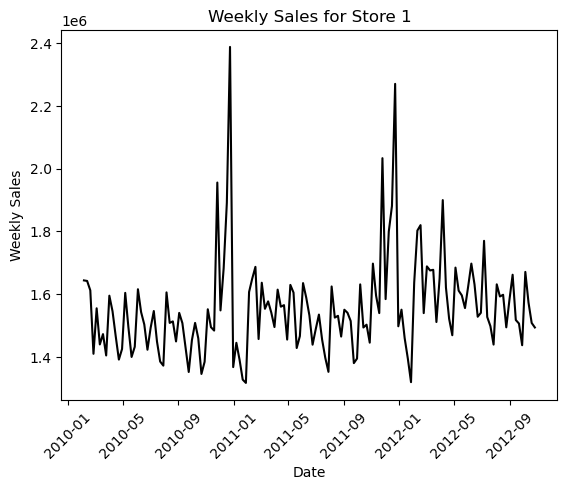

In [34]:
weekly_sales_store1['Date'] = pd.to_datetime(weekly_sales_store1['Date'])

# plot the line chart
plt.plot(weekly_sales_store1['Date'], weekly_sales_store1['Weekly_Sales'], color = 'black') 

# labeling the chart
plt.title('Weekly Sales for Store 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45);  # for visibility 

**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

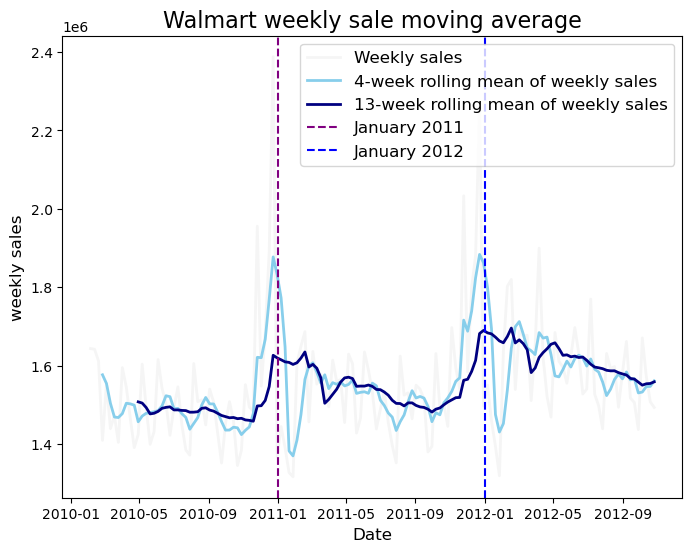

In [38]:
# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(weekly_sales_store1['Date'], weekly_sales_store1['Weekly_Sales'], color='whitesmoke', label='Weekly sales', linewidth=2)
plt.plot(weekly_sales_store1['Date'],weekly_sales_store1['Weekly_Sales'].rolling(4).mean(), color='skyblue', label='4-week rolling mean of weekly sales', linewidth=2)
plt.plot(weekly_sales_store1['Date'],weekly_sales_store1['Weekly_Sales'].rolling(13).mean(), color='navy', label='13-week rolling mean of weekly sales', linewidth=2)

# Add vertical lines for January 2011 and January 2012
plt.axvline(pd.to_datetime('2011-01-01'), color='purple', linestyle='--', label='January 2011')
plt.axvline(pd.to_datetime('2012-01-01'), color='blue', linestyle='--', label='January 2012')

# Add title, labels, and legend
plt.title('Walmart weekly sale moving average', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('weekly sales', fontsize=12)
plt.legend(fontsize=12);

**Describe any trends that you notice**

- The graph shows the trend of having a sales peak at or during end of the year time , which is Christmas and New year party
- After the great sales increased, it can be noticed that it started to droped down significantly after the New Year and Christmas time
- The sales started to normalized / downward trend until next seasonal time 

---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.

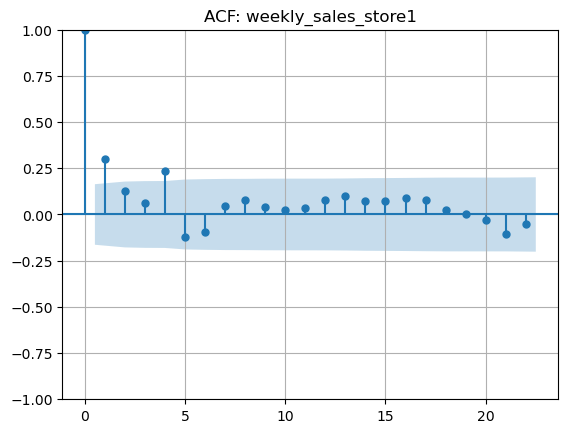

In [44]:
# ACF
plot_acf(weekly_sales_store1['Weekly_Sales'])
plt.title('ACF: weekly_sales_store1')
plt.grid(True)

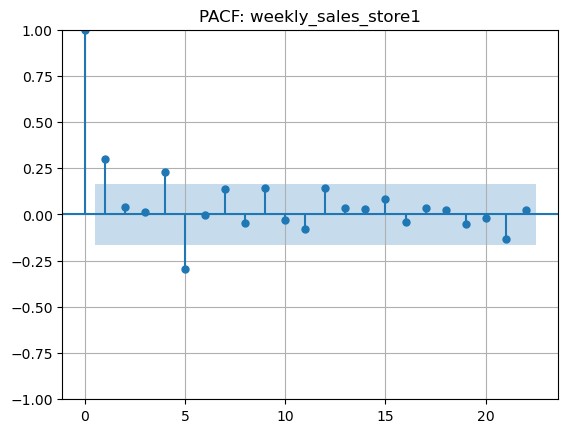

In [46]:
# PACF
plot_pacf(weekly_sales_store1['Weekly_Sales'])
plt.title('PACF: weekly_sales_store1')
plt.grid(True)

The ACF shows a seasonal trend, showing that the past sales value can be predict the future sales. While the PACF indicates that immediate past sales (lag-1) have the strongest influence on current weekly sales, and after that the sales have a less direct influence by the sales last week.

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [50]:
y = weekly_sales_store1['Weekly_Sales']

In [52]:
y_train, y_test = train_test_split(y, shuffle=False, test_size=0.1, random_state=42)

**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [55]:
adf_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(weekly_sales_store1['Weekly_Sales'].diff().diff().dropna())

# Standard way to report results
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
# Critical values from Dickey-Fuller distribution tables
print('\nCritical values:')
for key, value in critical_values.items():
   print(f'\t{key}: {value}')

ADF Statistic: -6.517398443328056
p-value: 1.0628787993961198e-08

Critical values:
	1%: -3.482920063655088
	5%: -2.884580323367261
	10%: -2.5790575441750883


ADF Statistic: -6.517398443328056
- A more negative value indicates stronger evidence against the null hypothesis of non-stationarity.
- more to be rejected Null Hypothesis

p-value: 1.0628787993961198e-08
- The p-value is extremely small , which means the null hypothesis can be rejected with high confidence.

Critical values:
- In this case, the ADF statistic (-6.517) is lower than all the critical values, meaning we can reject the null hypothesis even at the 1% level.

- Meaning that data is quite stationary, suitable for ARIMA model in time series 

---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.

In [59]:
model = ARIMA(y_train, order =(1,0,0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1710.923
Date:                Wed, 04 Dec 2024   AIC                           3427.846
Time:                        19:15:26   BIC                           3436.402
Sample:                             0   HQIC                          3431.323
                                - 128                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.556e+06   2.31e+04     67.488      0.000    1.51e+06     1.6e+06
ar.L1          0.3081      0.050      6.118      0.000       0.209       0.407
sigma2      2.397e+10      0.172   1.39e+11      0.000     2.4e+10     2.4e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               204.46
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.57   Skew:                             1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.91e+26. Standard errors may be unstable.
"""

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of **start** and **end** dates.

Generate and store predictions for the training and testing data.

In [62]:
y_test_pred = model.predict(start=y_test.index[0],end =y_test.index[-1])
y_train_pred = model.predict(start=y_train.index[0],end =y_train.index[-1])

**Mean squared error**

Use the [mean_squared_error](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_squared_error.html) function to identify the MSE on the testing data.

In [65]:
mse = mean_squared_error(y_test, y_test_pred)
mse

5188882502.605215

**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

In [68]:
def plot_predictions(y_train, y_test, train_preds, test_preds, title="Model ARIMA (1,0,0)"):

    #plot chart
    plt.figure(figsize=(12, 6))
    plt.plot(y_train, label="Training Data", color="blue")
    plt.plot(y_test, label="Testing Data", color="skyblue")
    plt.plot(y_train.index, train_preds, label="Train Predictions", color="green", linestyle="--")
    plt.plot(y_test.index, test_preds, label="Test Predictions", color="black", linestyle="--")
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()

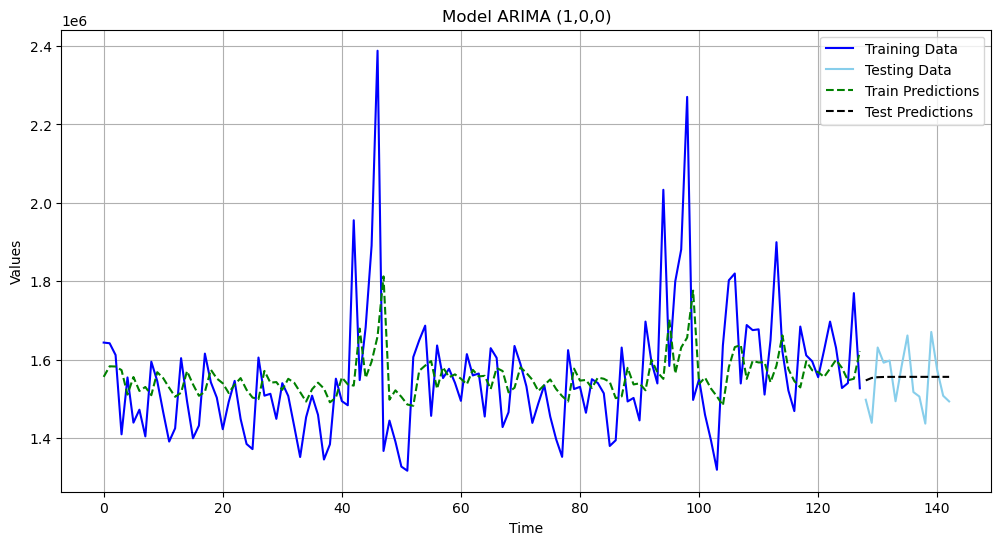

In [70]:
plot_predictions(y_train, y_test, y_train_pred, y_test_pred, title='Model ARIMA (1,0,0)')

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

The model perform poorly on predicting, it did not adapt any trend from the training data

---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [75]:
import warnings
warnings.filterwarnings("ignore")
model1 = ARIMA(y_train, order =(2,0,2)).fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [78]:
y_test_pred = model1.predict(start=y_test.index[0],end =y_test.index[-1])
y_train_pred = model1.predict(start=y_train.index[0],end =y_train.index[-1])

**Mean squared error**

Find the MSE of the testing data.

In [81]:
mse = mean_squared_error(y_test, y_test_pred)
mse

4617983455.870269

**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

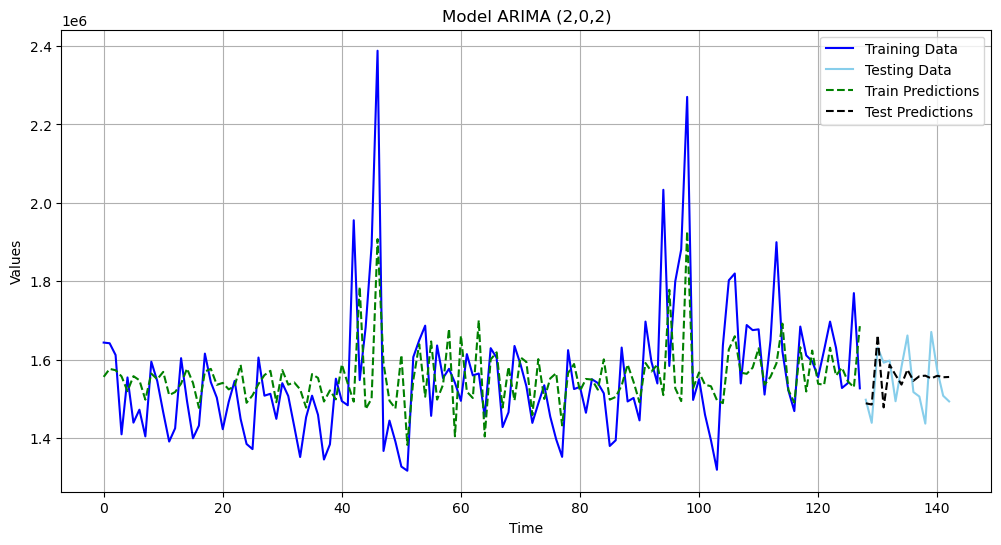

In [84]:
plot_predictions(y_train, y_test, y_train_pred, y_test_pred, title='Model ARIMA (2,0,2)')

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

The model performance is better compare to the previous model, it did almost accurately on the prediction on the near period of time. However, it still did not perform well when the time of predcition increases.

---

**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [89]:
model2 = ARIMA(y_train, order =(2,1,2)).fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [92]:
y_test_pred = model2.predict(start=y_test.index[0],end =y_test.index[-1])
y_train_pred = model2.predict(start=y_train.index[0],end =y_train.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [95]:
mse = mean_squared_error(y_test, y_test_pred)
mse

8383610278.299231

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

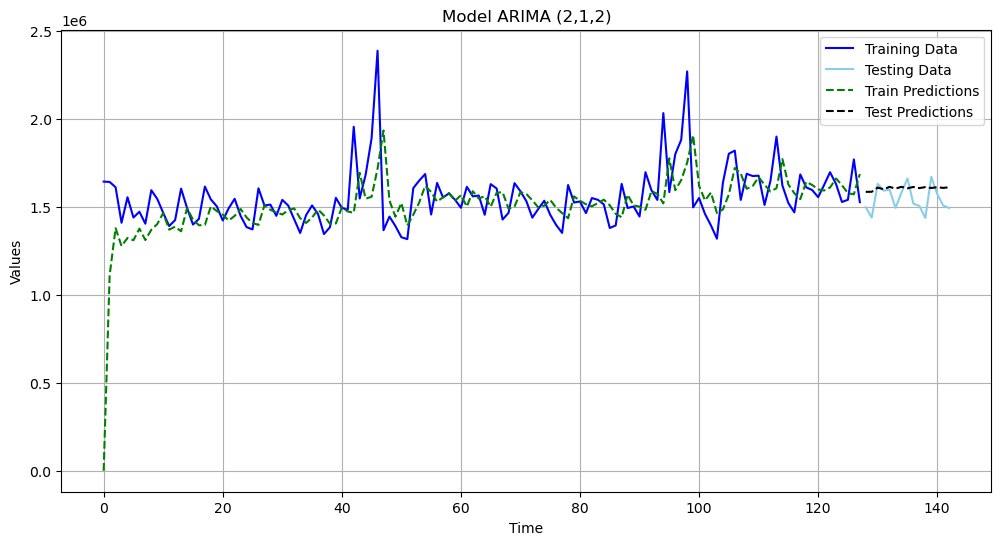

In [98]:
plot_predictions(y_train, y_test, y_train_pred, y_test_pred, title='Model ARIMA (2,1,2)')

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

The result is worsen than the second model 

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [103]:
model3 = ARIMA(y_train, order =(52,0,1)).fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [105]:
y_test_pred = model3.predict(start=y_test.index[0],end =y_test.index[-1])
y_train_pred = model3.predict(start=y_train.index[0],end =y_train.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [107]:
mse = mean_squared_error(y_test, y_test_pred)
mse

7894126414.596177

In [108]:
rmse = root_mean_squared_error(y_test, y_test_pred)
rmse

88848.8965299861

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

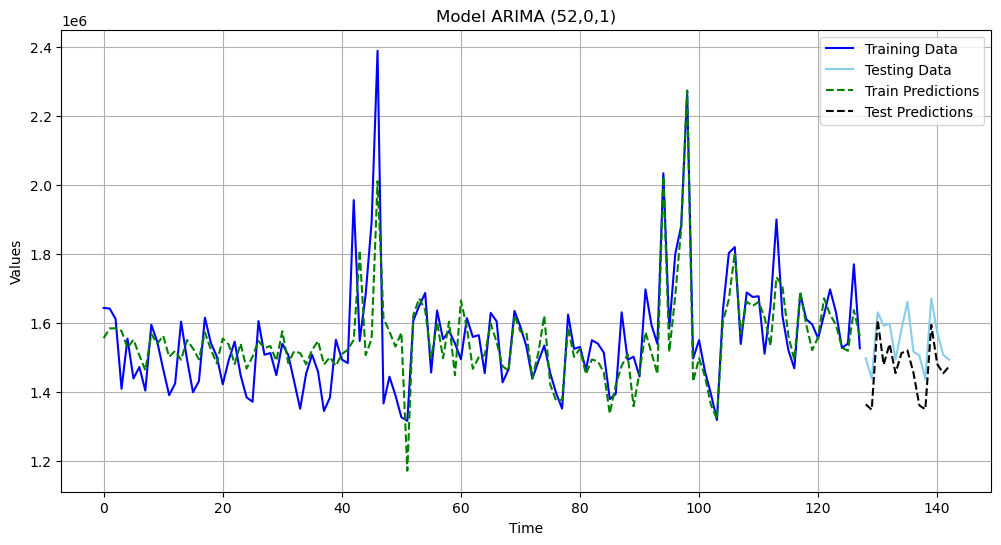

In [110]:
plot_predictions(y_train, y_test, y_train_pred, y_test_pred, title='Model ARIMA (52,0,1)')

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

The result of this one is better than the previous 2 models, as it capture all the trend that flautuate the sales , still have a high mse, and rmse 

---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

In [114]:
model4 = SARIMAX(y_train, order =(2,0,2), seasonal_order = (1,1,1,52)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.65908D+00    |proj g|=  5.49359D+00


 This problem is unconstrained.



At iterate    5    f=  7.57613D+00    |proj g|=  8.01876D-01

At iterate   10    f=  7.56777D+00    |proj g|=  3.01272D-01

At iterate   15    f=  7.47856D+00    |proj g|=  5.74045D-01

At iterate   20    f=  7.47468D+00    |proj g|=  2.62549D-01

At iterate   25    f=  7.46139D+00    |proj g|=  6.75317D-02

At iterate   30    f=  7.45753D+00    |proj g|=  5.16561D-03

At iterate   35    f=  7.45531D+00    |proj g|=  3.72976D-02

At iterate   40    f=  7.45416D+00    |proj g|=  2.01343D-02

At iterate   45    f=  7.45260D+00    |proj g|=  1.62773D-02

At iterate   50    f=  7.45230D+00    |proj g|=  1.58654D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [115]:
y_test_pred = model4.predict(start=y_test.index[0],end =y_test.index[-1])
y_train_pred = model4.predict(start=y_train.index[0],end =y_train.index[-1])

In [116]:
mse = mean_squared_error(y_test, y_test_pred)
mse

1890793068.13738

In [117]:
rmse = root_mean_squared_error(y_test, y_test_pred)
rmse

43483.25043206154

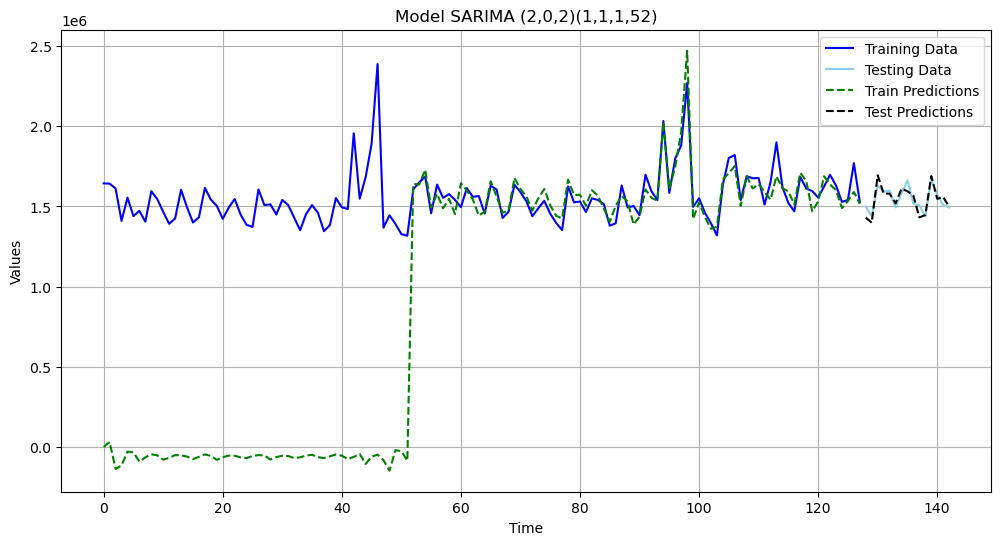

In [118]:
plot_predictions(y_train, y_test, y_train_pred, y_test_pred, title='Model SARIMA (2,0,2)(1,1,1,52)')

The result of this model is surpising for me, as it did well on predciting